In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV

from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df_results = pd.DataFrame()

In [3]:
# metrics for each class + weighted average (- bad impact)
# micro f1 = accuracy
def print_metrics(cls, X_test, y_test, balancing, phase_num):
    global df_results
    
    predicted = cls.predict(X_test)
    sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True, fmt='g', annot_kws={"size": 16})
    print('accuracy: ',metrics.accuracy_score(y_test, predicted))
    print()
    print(metrics.classification_report(y_test, predicted))
    print('macro precision: ',metrics.precision_score(y_test, predicted, average='macro'))
    print('micro precision: ',metrics.precision_score(y_test, predicted, average='micro'))
    print()
    print('micro recall: ',metrics.recall_score(y_test, predicted, average='micro'))
    print('macro recall: ',metrics.recall_score(y_test, predicted, average='macro'))
    print()
    print('micro f1: ',metrics.f1_score(y_test, predicted, average='micro'))
    print('macro f1: ',metrics.f1_score(y_test, predicted, average='macro'))
    
    df_result = pd.DataFrame({
        'Fáza': [phase_num],
        
        'Vyváženie': [balancing],
        
        'S': [round(metrics.accuracy_score(y_test, predicted), 2)],
        
        'P_0': [round(precision_score(y_test, cls.predict(X_test), average=None)[0], 2)],
        'P_1': [round(precision_score(y_test, cls.predict(X_test), average=None)[1], 2)],
        'P_2': [round(precision_score(y_test, cls.predict(X_test), average=None)[2], 2)],
        'P_3': [round(precision_score(y_test, cls.predict(X_test), average=None)[3], 2)],
        
        'Ú_0': [round(recall_score(y_test, cls.predict(X_test), average=None)[0], 2)],
        'Ú_1': [round(recall_score(y_test, cls.predict(X_test), average=None)[1], 2)],
        'Ú_2': [round(recall_score(y_test, cls.predict(X_test), average=None)[2], 2)],
        'Ú_3': [round(recall_score(y_test, cls.predict(X_test), average=None)[3], 2)],
        
        'F1_makro': [round(metrics.f1_score(y_test, predicted, average='macro'), 2)],
    })
        
    df_results = df_results.append(df_result, ignore_index=True)
    
    plt.show()

In [4]:
# tuning these HP
params = {
    'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2],
    'n_estimators': [150, 100, 50],
    'max_depth': [1, 2, 3, 4, 5],
    'random_state': [64],
}

# Creating final datasets

## Categorical data

In [5]:
# prepare categorical features (one hot encoded)
categorical_train = pd.read_csv('data/split/transformed/train_categories.csv', index_col=0)
categorical_test = pd.read_csv('data/split/transformed/test_categories.csv', index_col=0)
categorical_cv = pd.read_csv('data/split/transformed/cv_categories.csv', index_col=0)

In [6]:
categorical_train.shape

(18296, 60)

In [7]:
categorical_test.shape

(6099, 60)

In [8]:
categorical_cv.shape

(6100, 60)

## LSA groups

In [9]:
# prepare LSA groups
lsa_train = pd.read_csv('data/split/nlp/min_max_df/train_lsa.csv', index_col=0)
lsa_test = pd.read_csv('data/split/nlp/min_max_df/test_lsa.csv', index_col=0)
lsa_cv = pd.read_csv('data/split/nlp/min_max_df/cv_lsa.csv', index_col=0)

# contained in static+dynamic data
lsa_train.drop(['ratio_running_duration'], axis=1, inplace=True)
lsa_test.drop(['ratio_running_duration'], axis=1, inplace=True)
lsa_cv.drop(['ratio_running_duration'], axis=1, inplace=True)

# rename columns
lsa_train.rename(columns= lambda x: 'LSA_' + str(x), inplace=True)
lsa_test.rename(columns= lambda x: 'LSA_' + str(x), inplace=True)
lsa_cv.rename(columns= lambda x: 'LSA_' + str(x), inplace=True)

In [10]:
lsa_train.shape

(18296, 25)

In [11]:
lsa_test.shape

(6099, 25)

In [12]:
lsa_cv.shape

(6100, 25)

## LDA topics

In [13]:
# prepare LDA topics
lda_train = pd.read_csv('data/split/nlp/train_lda25.csv', index_col=0)
lda_test = pd.read_csv('data/split/nlp/test_lda25.csv', index_col=0)
lda_cv = pd.read_csv('data/split/nlp/cv_lda25.csv', index_col=0)

# contained in static+dynamic data
lda_train.drop(['ratio_running_duration'], axis=1, inplace=True)
lda_test.drop(['ratio_running_duration'], axis=1, inplace=True)
lda_cv.drop(['ratio_running_duration'], axis=1, inplace=True)

# rename columns
lda_train.rename(columns= lambda x: 'LDA_' + str(x), inplace=True)
lda_test.rename(columns= lambda x: 'LDA_' + str(x), inplace=True)
lda_cv.rename(columns= lambda x: 'LDA_' + str(x), inplace=True)

In [14]:
lda_train.shape

(18296, 25)

In [15]:
lda_test.shape

(6099, 25)

In [16]:
lda_cv.shape

(6100, 25)

## Original data (no scaling, no normalization)

We use only original data for the final models as we will only use GradientBoostingClassifier performs similarily with original and transformed data (maybe a bit better with original data).

In [17]:
# prepare original data 
train = pd.read_csv('data/split/transformed/train_original.csv', index_col=0)
test = pd.read_csv('data/split/transformed/test_original.csv', index_col=0)
cv = pd.read_csv('data/split/transformed/cv_original.csv', index_col=0)

# merge with categorical, lsa and lda
train = pd.concat([train, categorical_train, lsa_train, lda_train], axis=1)
test = pd.concat([test, categorical_test, lsa_test, lda_test], axis=1)
cv = pd.concat([cv, categorical_cv, lsa_cv, lda_cv], axis=1)

In [18]:
train.shape

(18296, 152)

In [19]:
test.shape

(6099, 152)

In [20]:
cv.shape

(6100, 152)

In [21]:
train.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18296 entries, 0 to 18295
Data columns (total 152 columns):
average_pledge                           18296 non-null float64
backers_count                            18296 non-null int64
category_position                        18296 non-null int64
days_duration                            18296 non-null int64
days_preparation                         18296 non-null int64
days_remaining                           18296 non-null int64
days_running                             18296 non-null int64
db_duration                              18296 non-null int64
goal                                     18296 non-null float64
pledged                                  18296 non-null float64
ratio_pledged_goal                       18296 non-null float64
ratio_running_duration                   18296 non-null float64
staff_pick                               18296 non-null int64
usd_goal                                 18296 non-null int64
usd_pledged 

In [22]:
train.to_csv('data/final/train.csv')
test.to_csv('data/final/test.csv')
cv.to_csv('data/final/cv.csv')

## First stage 0-25% of campaign duration

In [69]:
phase_num = 1

In [79]:
features = pd.read_csv('data/final/train.csv', index_col=0)
df = pd.read_csv('data/final/test.csv', index_col=0)
features = features.append(df, ignore_index=True)

features = features[features['ratio_running_duration'] < 25]

labels = features['class']
features = features.drop('class', axis=1)

features.shape

(6284, 151)

In [80]:
featuresCV = pd.read_csv('data/final/cv.csv', index_col=0)

featuresCV = featuresCV[featuresCV['ratio_running_duration'] < 25]

labelsCV = featuresCV['class']
featuresCV = featuresCV.drop('class', axis=1)

featuresCV.shape

(1572, 151)

### Feature selection

In [26]:
%%time
# remove highly corelated data
features.drop(['db_duration', 'goal'], axis=1, inplace=True)

# Recursive feature elimination using GBC with default parameters
selected_features = []
all_features = features.columns.tolist()
estimator = GradientBoostingClassifier(random_state=64)
selector = RFECV(estimator, step=1, cv=5, n_jobs=-1, scoring='accuracy')
selector = selector.fit(features, labels)

for i, support in zip(range(len(selector.support_)), selector.support_):
    if support:
        selected_features.append(all_features[i])

Wall time: 1h 32min 50s


In [88]:
selected_features

['average_pledge',
 'backers_count',
 'category_position',
 'days_duration',
 'days_preparation',
 'days_remaining',
 'days_running',
 'pledged',
 'ratio_pledged_goal',
 'ratio_running_duration',
 'usd_goal',
 'usd_pledged',
 'comments_count_public_while_scraping',
 'updates_likes_sum_while_scraping',
 'updates_likes_max_while_scraping',
 'deadline_day',
 'deadline_hour',
 'launch_month',
 'launch_day',
 'launch_hour',
 'image_count',
 'blurb_words',
 'category_parent_fashion',
 'location_type_Miscellaneous',
 'LSA_0',
 'LSA_1',
 'LSA_2',
 'LSA_3',
 'LSA_4',
 'LSA_5',
 'LSA_6',
 'LSA_7',
 'LSA_8',
 'LSA_9',
 'LSA_10',
 'LSA_11',
 'LSA_12',
 'LSA_13',
 'LSA_14',
 'LSA_15',
 'LSA_16',
 'LSA_17',
 'LSA_18',
 'LSA_19',
 'LSA_20',
 'LSA_21',
 'LSA_22',
 'LSA_23',
 'LSA_24',
 'LDA_0',
 'LDA_1',
 'LDA_2',
 'LDA_3',
 'LDA_4',
 'LDA_5',
 'LDA_6',
 'LDA_7',
 'LDA_8',
 'LDA_9',
 'LDA_10',
 'LDA_11',
 'LDA_12',
 'LDA_13',
 'LDA_14',
 'LDA_15',
 'LDA_16',
 'LDA_17',
 'LDA_18',
 'LDA_19',
 'LDA_20',

In [89]:
features = features[selected_features]
features.shape

(6284, 74)

In [90]:
featuresCV = featuresCV[selected_features]
featuresCV.shape

(1572, 74)

In [91]:
pd.Series(features.columns == featuresCV.columns).value_counts()

True    74
dtype: int64

### Training

#### Unbalanced

In [32]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [33]:
%%time
gs.fit(features, labels)

Wall time: 36min 31s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [34]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.74523, std: 0.00487, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.74491, std: 0.00371, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 100, 'random_state': 64},
 mean: 0.74475, std: 0.00301, params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.74459, std: 0.00766, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 100, 'random_state': 64},
 mean: 0.74459, std: 0.00552, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 64},
 mean: 0.74411, std: 0.00453, params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.74395, std: 0.00770, params: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.74379, std: 0.00757, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.74348, std: 0.00644, params: {'lea

In [35]:
best_unbalanced = gs.best_estimator_
best_unbalanced

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.756997455471

             precision    recall  f1-score   support

          1       0.87      0.97      0.91       659
          2       0.53      0.41      0.46       209
          3       0.60      0.60      0.60       336
          4       0.79      0.73      0.75       368

avg / total       0.75      0.76      0.75      1572

macro precision:  0.695165566841
micro precision:  0.756997455471

micro recall:  0.756997455471
macro recall:  0.674632788335

micro f1:  0.756997455471
macro f1:  0.681871384378


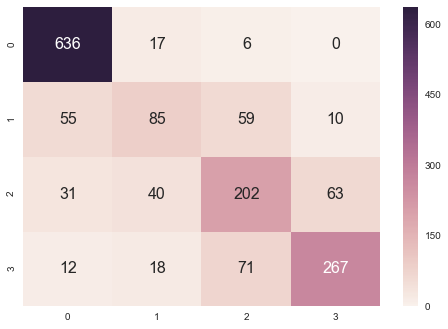

In [36]:
print_metrics(best_unbalanced, featuresCV, labelsCV, 'žiadne', phase_num)

#### Class weights

In [37]:
labels_weights = class_weight.compute_sample_weight('balanced', labels)

In [38]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [39]:
%%time
gs.fit(features, labels, sample_weight=labels_weights)

Wall time: 38min 7s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [40]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.73838, std: 0.01143, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.73822, std: 0.01352, params: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.73759, std: 0.01392, params: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.73504, std: 0.01247, params: {'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.73488, std: 0.01271, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.73456, std: 0.01480, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.73440, std: 0.01009, params: {'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.73409, std: 0.01272, params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.73377, std: 0.01365, params: {'le

In [41]:
best_weighted = gs.best_estimator_
best_weighted

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.732188295165

             precision    recall  f1-score   support

          1       0.90      0.90      0.90       659
          2       0.42      0.59      0.49       209
          3       0.61      0.51      0.56       336
          4       0.78      0.72      0.75       368

avg / total       0.75      0.73      0.74      1572

macro precision:  0.677252192081
micro precision:  0.732188295165

micro recall:  0.732188295165
macro recall:  0.679035904228

micro f1:  0.732188295165
macro f1:  0.673075236261


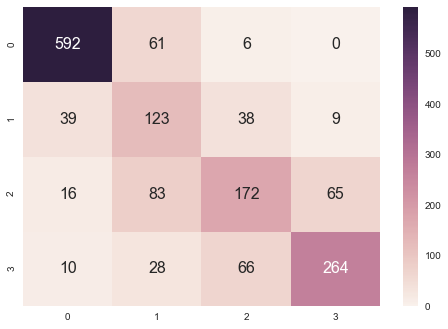

In [42]:
print_metrics(best_weighted, featuresCV, labelsCV, 'váhovanie', phase_num)

#### Oversampling

In [43]:
ros = RandomOverSampler(random_state=64)
features_sampled, labels_sampled = ros.fit_sample(features, labels)
print(sorted(Counter(labels_sampled).items()))

[(1, 2617), (2, 2617), (3, 2617), (4, 2617)]


In [44]:
features_sampled = pd.DataFrame(features_sampled)
features_sampled.columns = features.columns
features_sampled.shape

(10468, 74)

In [45]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [46]:
%%time
gs.fit(features_sampled, labels_sampled)

Wall time: 1h 16min 52s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [47]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.93093, std: 0.04037, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.92596, std: 0.04200, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.92358, std: 0.03934, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.92014, std: 0.04009, params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.91708, std: 0.03901, params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.90667, std: 0.03559, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.90457, std: 0.03969, params: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.89845, std: 0.03679, params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.89463, std: 0.03472, params: {'learn

In [48]:
best_oversampled = gs.best_estimator_

accuracy:  0.739185750636

             precision    recall  f1-score   support

          1       0.87      0.93      0.90       659
          2       0.45      0.44      0.45       209
          3       0.58      0.59      0.59       336
          4       0.79      0.71      0.75       368

avg / total       0.74      0.74      0.74      1572

macro precision:  0.67538508554
micro precision:  0.739185750636

micro recall:  0.739185750636
macro recall:  0.66662178935

micro f1:  0.739185750636
macro f1:  0.670192054374


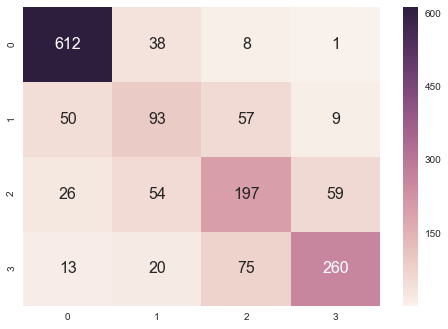

In [49]:
print_metrics(best_oversampled, featuresCV, labelsCV, 'nadvzorkovanie', phase_num)

#### Undersampling

In [50]:
rus = RandomUnderSampler(random_state=64)
features_sampled, labels_sampled = rus.fit_sample(features, labels)
print(sorted(Counter(labels_sampled).items()))

[(1, 832), (2, 832), (3, 832), (4, 832)]


In [51]:
features_sampled = pd.DataFrame(features_sampled)
features_sampled.columns = features.columns
features_sampled.shape

(3328, 74)

In [52]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [53]:
%%time
gs.fit(features_sampled, labels_sampled)

Wall time: 21min 32s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [54]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.68660, std: 0.00918, params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.68600, std: 0.00976, params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.68540, std: 0.01602, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.68540, std: 0.01637, params: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.68510, std: 0.01224, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.68269, std: 0.01347, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.68239, std: 0.01320, params: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.68209, std: 0.01607, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.68209, std: 0.01765, params: {'learn

In [55]:
best_undersampled = gs.best_estimator_
best_undersampled

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.719465648855

             precision    recall  f1-score   support

          1       0.90      0.89      0.90       659
          2       0.40      0.60      0.48       209
          3       0.59      0.47      0.52       336
          4       0.77      0.71      0.74       368

avg / total       0.74      0.72      0.72      1572

macro precision:  0.664582803025
micro precision:  0.719465648855

micro recall:  0.719465648855
macro recall:  0.666412055124

micro f1:  0.719465648855
macro f1:  0.658424352869


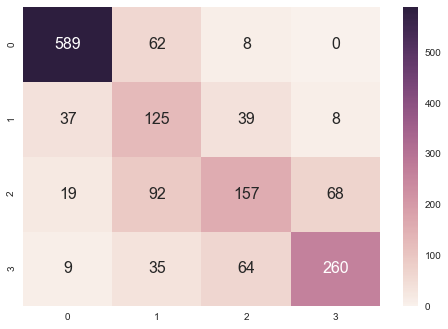

In [56]:
print_metrics(best_undersampled, featuresCV, labelsCV, 'podvzorkovanie', phase_num)

### Best configuration (primary: accuracy, secondary: macro F1)

In [68]:
df_results[['Fáza','Vyváženie','S','P_0','P_1','P_2','P_3','Ú_0','Ú_1','Ú_2','Ú_3', 'F1_makro']] \
.sort_values(by=['Fáza', 'S', 'F1_makro'], ascending=False)

,Fáza,Vyváženie,S,P_0,P_1,P_2,P_3,Ú_0,Ú_1,Ú_2,Ú_3,F1_makro
0,1,žiadne,0.76,0.87,0.53,0.60,0.79,0.97,0.41,0.60,0.73,0.68
2,1,oversampling,0.74,0.87,0.45,0.58,0.79,0.93,0.44,0.59,0.71,0.67
1,1,váhovanie,0.73,0.90,0.42,0.61,0.78,0.90,0.59,0.51,0.72,0.67
3,1,undersampling,0.72,0.90,0.40,0.59,0.77,0.89,0.60,0.47,0.71,0.66


In [61]:
best = best_unbalanced
best

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

In [70]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, best.feature_importances_):
    importances.loc[i, 'názov črty'] = name
    importances.loc[i, 'dôležitosť'] = importance
    
importances.sort_values(by='dôležitosť', ascending=False).to_csv('results/importances'+ str(phase_num) +'.csv')
importances.sort_values(by='dôležitosť', ascending=False)

,názov črty,dôležitosť
8,ratio_pledged_goal,0.194008
10,usd_goal,0.040100
9,ratio_running_duration,0.027154
30,LSA_6,0.024368
50,LDA_1,0.021664
29,LSA_5,0.020299
53,LDA_4,0.019012
63,LDA_14,0.018956
0,average_pledge,0.017454
7,pledged,0.017066


### Save confusion matrices

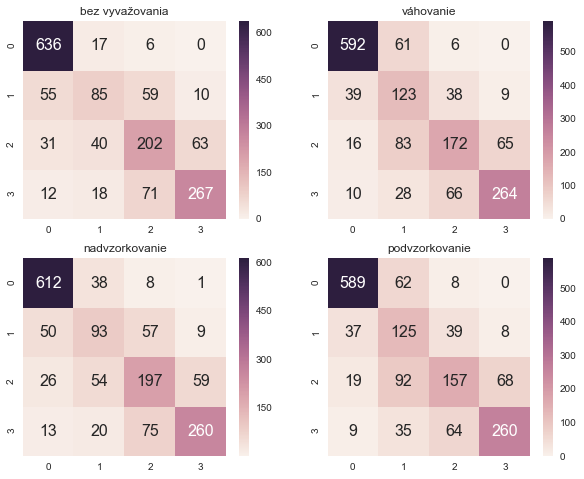

In [86]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(10, 8))

sns.heatmap(metrics.confusion_matrix(labelsCV, best_unbalanced.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[0][0])
ax[0][0].set(xlabel='', ylabel='', title='bez vyvažovania')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_weighted.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[0][1])
ax[0][1].set(xlabel='', ylabel='', title='váhovanie')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_oversampled.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[1][0])
ax[1][0].set(xlabel='', ylabel='', title='nadvzorkovanie')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_undersampled.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[1][1])
ax[1][1].set(xlabel='', ylabel='', title='podvzorkovanie')

fig.savefig('img/matrices1.png', dpi=400)

In [72]:
df_results[['Fáza','Vyváženie','S','P_0','P_1','P_2','P_3','Ú_0','Ú_1','Ú_2','Ú_3', 'F1_makro']].to_csv('results/final.csv')

## Second stage 25-50% of campaign duration

In [92]:
phase_num = 2

In [93]:
features = pd.read_csv('data/final/train.csv', index_col=0)
df = pd.read_csv('data/final/test.csv', index_col=0)
features = features.append(df, ignore_index=True)

features = features[(features['ratio_running_duration'] < 50) & (features['ratio_running_duration'] >= 25)]

labels = features['class']
features = features.drop('class', axis=1)

features.shape

(6231, 151)

In [94]:
featuresCV = pd.read_csv('data/final/cv.csv', index_col=0)

featuresCV = featuresCV[(featuresCV['ratio_running_duration'] < 50) & (featuresCV['ratio_running_duration'] >= 25)]

labelsCV = featuresCV['class']
featuresCV = featuresCV.drop('class', axis=1)

featuresCV.shape

(1558, 151)

### Feature selection

In [95]:
%%time
# remove highly corelated data
features.drop(['db_duration', 'goal'], axis=1, inplace=True)

# Recursive feature elimination using GBC with default parameters
selected_features = []
all_features = features.columns.tolist()
estimator = GradientBoostingClassifier(random_state=64)
selector = RFECV(estimator, step=1, cv=5, n_jobs=-1, scoring='accuracy')
selector = selector.fit(features, labels)

for i, support in zip(range(len(selector.support_)), selector.support_):
    if support:
        selected_features.append(all_features[i])

Wall time: 1h 25min 53s


In [96]:
selected_features

['average_pledge',
 'backers_count',
 'category_position',
 'days_preparation',
 'days_remaining',
 'days_running',
 'pledged',
 'ratio_pledged_goal',
 'ratio_running_duration',
 'staff_pick',
 'usd_goal',
 'usd_pledged',
 'faq_count_while_scraping',
 'comments_count_creator_while_scraping',
 'comments_count_public_while_scraping',
 'updates_count_while_scraping',
 'updates_likes_sum_while_scraping',
 'updates_likes_mean_while_scraping',
 'updates_likes_min_while_scraping',
 'updates_likes_max_while_scraping',
 'updates_likes_median_while_scraping',
 'deadline_month',
 'deadline_day',
 'deadline_dayofweek',
 'deadline_hour',
 'launch_month',
 'launch_day',
 'launch_dayofweek',
 'launch_hour',
 'image_count',
 'video_kickstarter_count',
 'video_youtube_count',
 'video_count',
 'blurb_words',
 'category_parent_art',
 'category_parent_comics',
 'category_parent_crafts',
 'category_parent_dance',
 'category_parent_fashion',
 'category_parent_film & video',
 'category_parent_journalism',
 '

In [97]:
features = features[selected_features]
features.shape

(6231, 107)

In [98]:
featuresCV = featuresCV[selected_features]
featuresCV.shape

(1558, 107)

In [99]:
pd.Series(features.columns == featuresCV.columns).value_counts()

True    107
dtype: int64

### Training

#### Unbalanced

In [100]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [101]:
%%time
gs.fit(features, labels)

Wall time: 45min 10s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [102]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82122, std: 0.00834, params: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 50, 'random_state': 64},
 mean: 0.82122, std: 0.00424, params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.82106, std: 0.00814, params: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 50, 'random_state': 64},
 mean: 0.82090, std: 0.00651, params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.82090, std: 0.00661, params: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.82074, std: 0.00611, params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 64},
 mean: 0.82057, std: 0.00383, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.82041, std: 0.00709, params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.82041, std: 0.00870, params: {'learni

In [103]:
best_unbalanced = gs.best_estimator_
best_unbalanced

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.810654685494

             precision    recall  f1-score   support

          1       0.92      0.98      0.95       626
          2       0.60      0.52      0.56       198
          3       0.66      0.72      0.69       360
          4       0.87      0.77      0.82       374

avg / total       0.81      0.81      0.81      1558

macro precision:  0.763717166043
micro precision:  0.810654685494

micro recall:  0.810654685494
macro recall:  0.746934198212

micro f1:  0.810654685494
macro f1:  0.75328102489


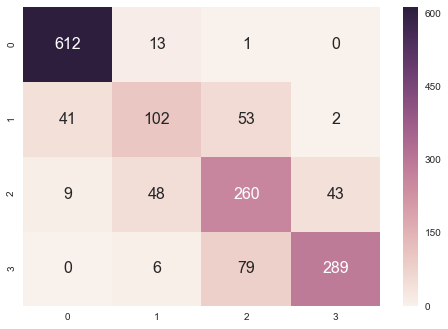

In [104]:
print_metrics(best_unbalanced, featuresCV, labelsCV, 'žiadne', phase_num)

#### Class weights

In [105]:
labels_weights = class_weight.compute_sample_weight('balanced', labels)

In [106]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [107]:
%%time
gs.fit(features, labels, sample_weight=labels_weights)

Wall time: 42min 7s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [108]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82025, std: 0.01046, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 50, 'random_state': 64},
 mean: 0.81897, std: 0.00953, params: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 50, 'random_state': 64},
 mean: 0.81849, std: 0.00908, params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'random_state': 64},
 mean: 0.81817, std: 0.00481, params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.81801, std: 0.00920, params: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.81785, std: 0.00997, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 100, 'random_state': 64},
 mean: 0.81785, std: 0.00641, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.81785, std: 0.00771, params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.81785, std: 0.00848, params: {'learn

In [109]:
best_weighted = gs.best_estimator_
best_weighted

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.806803594352

             precision    recall  f1-score   support

          1       0.93      0.97      0.95       626
          2       0.55      0.58      0.56       198
          3       0.67      0.68      0.67       360
          4       0.88      0.78      0.83       374

avg / total       0.81      0.81      0.81      1558

macro precision:  0.756416166834
micro precision:  0.806803594352

micro recall:  0.806803594352
macro recall:  0.751308233624

micro f1:  0.806803594352
macro f1:  0.752761439162


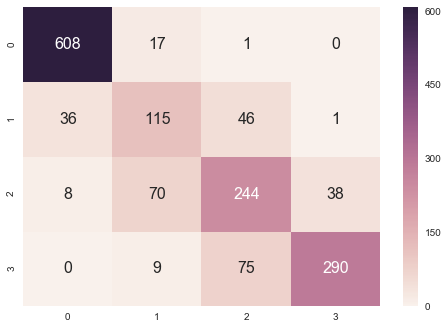

In [110]:
print_metrics(best_weighted, featuresCV, labelsCV, 'váhovanie', phase_num)

#### Oversampling

In [111]:
ros = RandomOverSampler(random_state=64)
features_sampled, labels_sampled = ros.fit_sample(features, labels)
print(sorted(Counter(labels_sampled).items()))

[(1, 2519), (2, 2519), (3, 2519), (4, 2519)]


In [112]:
features_sampled = pd.DataFrame(features_sampled)
features_sampled.columns = features.columns
features_sampled.shape

(10076, 107)

In [113]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [114]:
%%time
gs.fit(features_sampled, labels_sampled)

Wall time: 1h 28min 53s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [115]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.95038, std: 0.03356, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.94889, std: 0.03664, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.94800, std: 0.03707, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.94591, std: 0.03480, params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.94541, std: 0.03350, params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.93956, std: 0.03177, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.93817, std: 0.03079, params: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.93261, std: 0.03075, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'random_state': 64},
 mean: 0.93182, std: 0.02986, params: {'learni

In [116]:
best_oversampled = gs.best_estimator_

accuracy:  0.807445442875

             precision    recall  f1-score   support

          1       0.93      0.98      0.95       626
          2       0.56      0.56      0.56       198
          3       0.66      0.69      0.68       360
          4       0.87      0.77      0.82       374

avg / total       0.81      0.81      0.81      1558

macro precision:  0.757106823133
micro precision:  0.807445442875

micro recall:  0.807445442875
macro recall:  0.748059421029

micro f1:  0.807445442875
macro f1:  0.751505881467


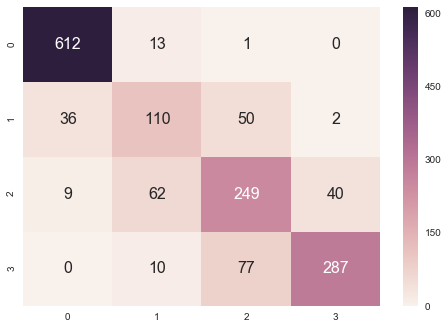

In [117]:
print_metrics(best_oversampled, featuresCV, labelsCV, 'nadvzorkovanie', phase_num)

#### Undersampling

In [118]:
rus = RandomUnderSampler(random_state=64)
features_sampled, labels_sampled = rus.fit_sample(features, labels)
print(sorted(Counter(labels_sampled).items()))

[(1, 756), (2, 756), (3, 756), (4, 756)]


In [119]:
features_sampled = pd.DataFrame(features_sampled)
features_sampled.columns = features.columns
features_sampled.shape

(3024, 107)

In [120]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [121]:
%%time
gs.fit(features_sampled, labels_sampled)

Wall time: 23min 31s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [122]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.77447, std: 0.00895, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 50, 'random_state': 64},
 mean: 0.77414, std: 0.00699, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 50, 'random_state': 64},
 mean: 0.77282, std: 0.00654, params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.77216, std: 0.00731, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.77149, std: 0.00311, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'random_state': 64},
 mean: 0.76918, std: 0.00487, params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.76918, std: 0.00997, params: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 50, 'random_state': 64},
 mean: 0.76885, std: 0.00649, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 100, 'random_state': 64},
 mean: 0.76885, std: 0.01051, params: {'learnin

In [123]:
best_undersampled = gs.best_estimator_
best_undersampled

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.793324775353

             precision    recall  f1-score   support

          1       0.94      0.96      0.95       626
          2       0.51      0.66      0.58       198
          3       0.66      0.61      0.64       360
          4       0.86      0.76      0.81       374

avg / total       0.80      0.79      0.80      1558

macro precision:  0.743644914278
micro precision:  0.793324775353

micro recall:  0.793324775353
macro recall:  0.748037364815

micro f1:  0.793324775353
macro f1:  0.742430122288


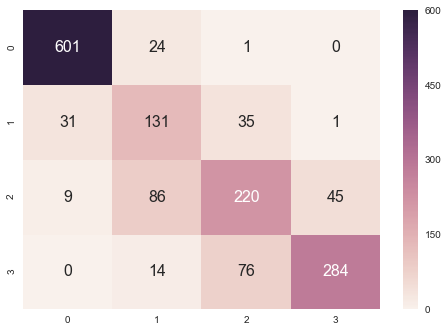

In [124]:
print_metrics(best_undersampled, featuresCV, labelsCV, 'podvzorkovanie', phase_num)

### Best configuration (primary: accuracy, secondary: macro F1)

In [125]:
df_results[['Fáza','Vyváženie','S','P_0','P_1','P_2','P_3','Ú_0','Ú_1','Ú_2','Ú_3', 'F1_makro']] \
.sort_values(by=['Fáza', 'S', 'F1_makro'], ascending=False)

,Fáza,Vyváženie,S,P_0,P_1,P_2,P_3,Ú_0,Ú_1,Ú_2,Ú_3,F1_makro
4,2,žiadne,0.81,0.92,0.60,0.66,0.87,0.98,0.52,0.72,0.77,0.75
5,2,váhovanie,0.81,0.93,0.55,0.67,0.88,0.97,0.58,0.68,0.78,0.75
6,2,nadvzorkovanie,0.81,0.93,0.56,0.66,0.87,0.98,0.56,0.69,0.77,0.75
7,2,podvzorkovanie,0.79,0.94,0.51,0.66,0.86,0.96,0.66,0.61,0.76,0.74
0,1,žiadne,0.76,0.87,0.53,0.60,0.79,0.97,0.41,0.60,0.73,0.68
2,1,oversampling,0.74,0.87,0.45,0.58,0.79,0.93,0.44,0.59,0.71,0.67
1,1,váhovanie,0.73,0.90,0.42,0.61,0.78,0.90,0.59,0.51,0.72,0.67
3,1,undersampling,0.72,0.90,0.40,0.59,0.77,0.89,0.60,0.47,0.71,0.66


In [126]:
best = best_unbalanced
best

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

In [127]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, best.feature_importances_):
    importances.loc[i, 'názov črty'] = name
    importances.loc[i, 'dôležitosť'] = importance
    
importances.sort_values(by='dôležitosť', ascending=False).to_csv('results/importances'+ str(phase_num) +'.csv')
importances.sort_values(by='dôležitosť', ascending=False)

,názov črty,dôležitosť
7,ratio_pledged_goal,4.291494e-01
0,average_pledge,2.045852e-02
10,usd_goal,2.034916e-02
1,backers_count,1.813570e-02
106,LDA_24,1.464045e-02
91,LDA_9,1.367263e-02
11,usd_pledged,1.338685e-02
96,LDA_14,1.174503e-02
83,LDA_1,1.128907e-02
100,LDA_18,1.109476e-02


### Save confusion matrices

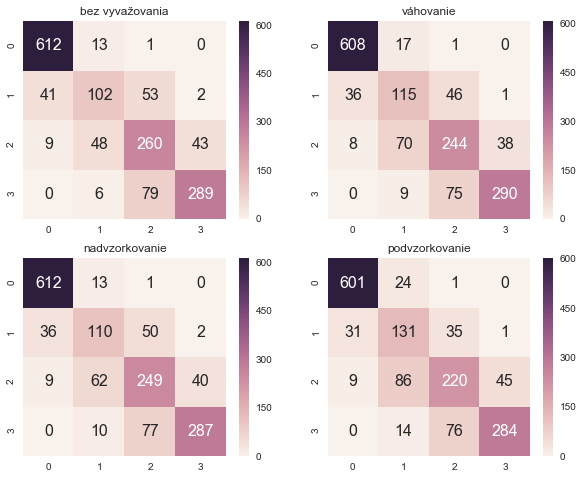

In [129]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(10, 8))

sns.heatmap(metrics.confusion_matrix(labelsCV, best_unbalanced.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[0][0])
ax[0][0].set(xlabel='', ylabel='', title='bez vyvažovania')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_weighted.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[0][1])
ax[0][1].set(xlabel='', ylabel='', title='váhovanie')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_oversampled.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[1][0])
ax[1][0].set(xlabel='', ylabel='', title='nadvzorkovanie')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_undersampled.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[1][1])
ax[1][1].set(xlabel='', ylabel='', title='podvzorkovanie')

fig.savefig('img/matrices2.png', dpi=400)

In [130]:
df_results[['Fáza','Vyváženie','S','P_0','P_1','P_2','P_3','Ú_0','Ú_1','Ú_2','Ú_3', 'F1_makro']].to_csv('results/final.csv')

## Third stage 50-75% of campaign duration

In [131]:
phase_num = 3

In [132]:
features = pd.read_csv('data/final/train.csv', index_col=0)
df = pd.read_csv('data/final/test.csv', index_col=0)
features = features.append(df, ignore_index=True)

features = features[(features['ratio_running_duration'] < 75) & (features['ratio_running_duration'] >= 50)]

labels = features['class']
features = features.drop('class', axis=1)

features.shape

(6192, 151)

In [133]:
featuresCV = pd.read_csv('data/final/cv.csv', index_col=0)

featuresCV = featuresCV[(featuresCV['ratio_running_duration'] < 75) & (featuresCV['ratio_running_duration'] >= 50)]

labelsCV = featuresCV['class']
featuresCV = featuresCV.drop('class', axis=1)

featuresCV.shape

(1548, 151)

### Feature selection

In [134]:
%%time
# remove highly corelated data
features.drop(['db_duration', 'goal'], axis=1, inplace=True)

# Recursive feature elimination using GBC with default parameters
selected_features = []
all_features = features.columns.tolist()
estimator = GradientBoostingClassifier(random_state=64)
selector = RFECV(estimator, step=1, cv=5, n_jobs=-1, scoring='accuracy')
selector = selector.fit(features, labels)

for i, support in zip(range(len(selector.support_)), selector.support_):
    if support:
        selected_features.append(all_features[i])

Wall time: 1h 30min 13s


In [135]:
selected_features

['average_pledge',
 'backers_count',
 'category_position',
 'days_preparation',
 'pledged',
 'ratio_pledged_goal',
 'ratio_running_duration',
 'usd_goal',
 'usd_pledged',
 'comments_count_creator_while_scraping',
 'comments_count_public_while_scraping',
 'updates_likes_mean_while_scraping',
 'deadline_hour',
 'image_count',
 'video_kickstarter_count',
 'category_parent_fashion',
 'category_parent_theater',
 'LSA_0',
 'LSA_1',
 'LSA_2',
 'LSA_3',
 'LSA_4',
 'LSA_5',
 'LSA_6',
 'LSA_9',
 'LSA_10',
 'LSA_11',
 'LSA_12',
 'LSA_13',
 'LSA_14',
 'LSA_15',
 'LSA_16',
 'LSA_17',
 'LSA_18',
 'LSA_19',
 'LSA_21',
 'LSA_22',
 'LSA_23',
 'LSA_24',
 'LDA_0',
 'LDA_1',
 'LDA_2',
 'LDA_3',
 'LDA_4',
 'LDA_6',
 'LDA_7',
 'LDA_8',
 'LDA_9',
 'LDA_10',
 'LDA_11',
 'LDA_12',
 'LDA_13',
 'LDA_14',
 'LDA_15',
 'LDA_16',
 'LDA_17',
 'LDA_18',
 'LDA_19',
 'LDA_20',
 'LDA_21',
 'LDA_22',
 'LDA_23',
 'LDA_24']

In [136]:
features = features[selected_features]
features.shape

(6192, 63)

In [137]:
featuresCV = featuresCV[selected_features]
featuresCV.shape

(1548, 63)

In [138]:
pd.Series(features.columns == featuresCV.columns).value_counts()

True    63
dtype: int64

### Training

#### Unbalanced

In [139]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [140]:
%%time
gs.fit(features, labels)

Wall time: 29min 55s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [141]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.85950, std: 0.00413, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.85901, std: 0.00421, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.85869, std: 0.00493, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.85869, std: 0.00694, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.85853, std: 0.00578, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.85804, std: 0.00426, params: {'learning_rate': 0.08, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.85804, std: 0.00501, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.85788, std: 0.00439, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.85788, std: 0.00602, params: {'learni

In [142]:
best_unbalanced = gs.best_estimator_
best_unbalanced

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.850775193798

             precision    recall  f1-score   support

          1       0.96      0.99      0.97       684
          2       0.70      0.66      0.68       190
          3       0.69      0.75      0.72       343
          4       0.88      0.77      0.82       331

avg / total       0.85      0.85      0.85      1548

macro precision:  0.808553110323
micro precision:  0.850775193798

micro recall:  0.850775193798
macro recall:  0.793904383907

micro f1:  0.850775193798
macro f1:  0.799883306775


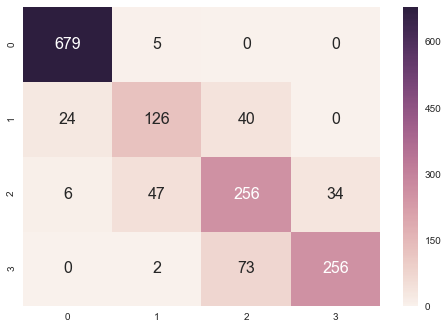

In [143]:
print_metrics(best_unbalanced, featuresCV, labelsCV, 'žiadne', phase_num)

#### Class weights

In [144]:
labels_weights = class_weight.compute_sample_weight('balanced', labels)

In [145]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [146]:
%%time
gs.fit(features, labels, sample_weight=labels_weights)

Wall time: 30min 23s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [147]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.85481, std: 0.00301, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.85449, std: 0.00396, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.85449, std: 0.00448, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.85401, std: 0.00360, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.85320, std: 0.00403, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.85304, std: 0.00553, params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.85287, std: 0.00401, params: {'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.85255, std: 0.00305, params: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.85239, std: 0.00401, params: {'le

In [148]:
best_weighted = gs.best_estimator_
best_weighted

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.844315245478

             precision    recall  f1-score   support

          1       0.96      0.98      0.97       684
          2       0.67      0.71      0.69       190
          3       0.69      0.73      0.71       343
          4       0.87      0.76      0.81       331

avg / total       0.85      0.84      0.84      1548

macro precision:  0.799332583513
micro precision:  0.844315245478

micro recall:  0.844315245478
macro recall:  0.794309533776

micro f1:  0.844315245478
macro f1:  0.795505404126


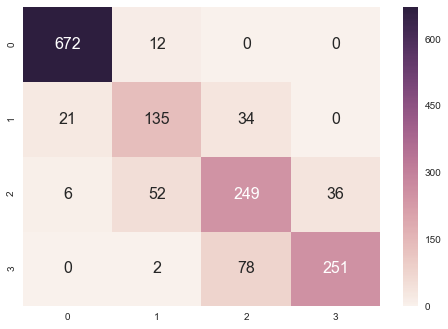

In [149]:
print_metrics(best_weighted, featuresCV, labelsCV, 'váhovanie', phase_num)

#### Oversampling

In [150]:
ros = RandomOverSampler(random_state=64)
features_sampled, labels_sampled = ros.fit_sample(features, labels)
print(sorted(Counter(labels_sampled).items()))

[(1, 2628), (2, 2628), (3, 2628), (4, 2628)]


In [151]:
features_sampled = pd.DataFrame(features_sampled)
features_sampled.columns = features.columns
features_sampled.shape

(10512, 63)

In [152]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [153]:
%%time
gs.fit(features_sampled, labels_sampled)

Wall time: 1h 35s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [154]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.96433, std: 0.02513, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.96357, std: 0.02488, params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.96328, std: 0.02559, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.96309, std: 0.02586, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.96033, std: 0.02514, params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.95529, std: 0.02232, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.95462, std: 0.02404, params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.95367, std: 0.02383, params: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.94977, std: 0.02296, params: {'learn

In [155]:
best_oversampled = gs.best_estimator_

accuracy:  0.844315245478

             precision    recall  f1-score   support

          1       0.96      0.99      0.97       684
          2       0.67      0.69      0.68       190
          3       0.69      0.72      0.71       343
          4       0.87      0.76      0.81       331

avg / total       0.85      0.84      0.84      1548

macro precision:  0.797436854132
micro precision:  0.844315245478

micro recall:  0.844315245478
macro recall:  0.791874870552

micro f1:  0.844315245478
macro f1:  0.793614585036


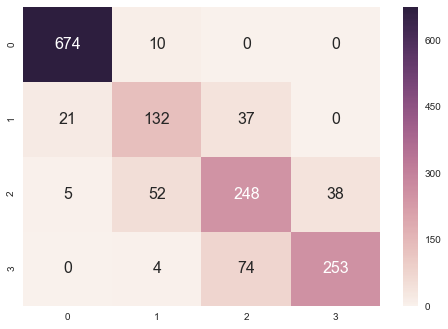

In [156]:
print_metrics(best_oversampled, featuresCV, labelsCV, 'nadvzorkovanie', phase_num)

#### Undersampling

In [157]:
rus = RandomUnderSampler(random_state=64)
features_sampled, labels_sampled = rus.fit_sample(features, labels)
print(sorted(Counter(labels_sampled).items()))

[(1, 813), (2, 813), (3, 813), (4, 813)]


In [158]:
features_sampled = pd.DataFrame(features_sampled)
features_sampled.columns = features.columns
features_sampled.shape

(3252, 63)

In [159]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [160]:
%%time
gs.fit(features_sampled, labels_sampled)

Wall time: 17min 12s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [161]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.81765, std: 0.00812, params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.81673, std: 0.00830, params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.81611, std: 0.00760, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.81550, std: 0.00806, params: {'learning_rate': 0.08, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.81488, std: 0.00651, params: {'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.81488, std: 0.00547, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.81458, std: 0.00879, params: {'learning_rate': 0.08, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.81427, std: 0.00667, params: {'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.81427, std: 0.00798, params: {'lear

In [162]:
best_undersampled = gs.best_estimator_
best_undersampled

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.837855297158

             precision    recall  f1-score   support

          1       0.98      0.96      0.97       684
          2       0.60      0.81      0.69       190
          3       0.71      0.68      0.69       343
          4       0.87      0.77      0.82       331

avg / total       0.85      0.84      0.84      1548

macro precision:  0.788754987546
micro precision:  0.837855297158

micro recall:  0.837855297158
macro recall:  0.803531555578

micro f1:  0.837855297158
macro f1:  0.791574359388


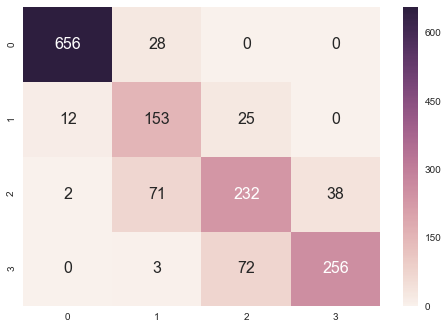

In [163]:
print_metrics(best_undersampled, featuresCV, labelsCV, 'podvzorkovanie', phase_num)

### Best configuration (primary: accuracy, secondary: macro F1)

In [164]:
df_results[['Fáza','Vyváženie','S','P_0','P_1','P_2','P_3','Ú_0','Ú_1','Ú_2','Ú_3', 'F1_makro']] \
.sort_values(by=['Fáza', 'S', 'F1_makro'], ascending=False)

,Fáza,Vyváženie,S,P_0,P_1,P_2,P_3,Ú_0,Ú_1,Ú_2,Ú_3,F1_makro
8,3,žiadne,0.85,0.96,0.70,0.69,0.88,0.99,0.66,0.75,0.77,0.80
9,3,váhovanie,0.84,0.96,0.67,0.69,0.87,0.98,0.71,0.73,0.76,0.80
10,3,nadvzorkovanie,0.84,0.96,0.67,0.69,0.87,0.99,0.69,0.72,0.76,0.79
11,3,podvzorkovanie,0.84,0.98,0.60,0.71,0.87,0.96,0.81,0.68,0.77,0.79
4,2,žiadne,0.81,0.92,0.60,0.66,0.87,0.98,0.52,0.72,0.77,0.75
5,2,váhovanie,0.81,0.93,0.55,0.67,0.88,0.97,0.58,0.68,0.78,0.75
6,2,nadvzorkovanie,0.81,0.93,0.56,0.66,0.87,0.98,0.56,0.69,0.77,0.75
7,2,podvzorkovanie,0.79,0.94,0.51,0.66,0.86,0.96,0.66,0.61,0.76,0.74
0,1,žiadne,0.76,0.87,0.53,0.60,0.79,0.97,0.41,0.60,0.73,0.68
2,1,oversampling,0.74,0.87,0.45,0.58,0.79,0.93,0.44,0.59,0.71,0.67


In [165]:
best = best_unbalanced
best

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

In [166]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, best.feature_importances_):
    importances.loc[i, 'názov črty'] = name
    importances.loc[i, 'dôležitosť'] = importance
    
importances.sort_values(by='dôležitosť', ascending=False).to_csv('results/importances'+ str(phase_num) +'.csv')
importances.sort_values(by='dôležitosť', ascending=False)

,názov črty,dôležitosť
5,ratio_pledged_goal,0.267784
46,LDA_8,0.025658
0,average_pledge,0.025105
40,LDA_1,0.025074
41,LDA_2,0.022893
4,pledged,0.018957
7,usd_goal,0.018376
23,LSA_6,0.018321
20,LSA_3,0.017335
8,usd_pledged,0.017109


### Save confusion matrices

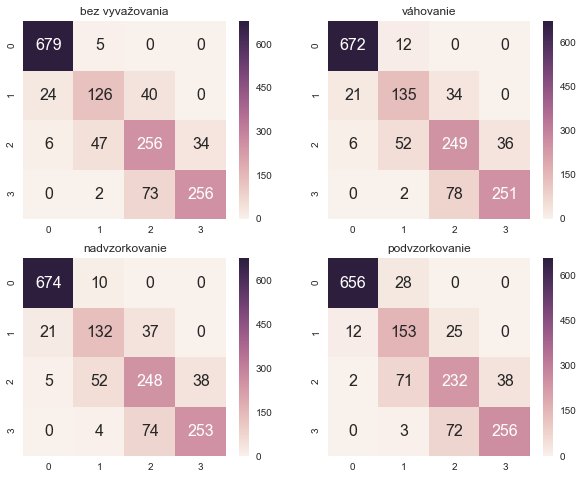

In [167]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(10, 8))

sns.heatmap(metrics.confusion_matrix(labelsCV, best_unbalanced.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[0][0])
ax[0][0].set(xlabel='', ylabel='', title='bez vyvažovania')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_weighted.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[0][1])
ax[0][1].set(xlabel='', ylabel='', title='váhovanie')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_oversampled.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[1][0])
ax[1][0].set(xlabel='', ylabel='', title='nadvzorkovanie')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_undersampled.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[1][1])
ax[1][1].set(xlabel='', ylabel='', title='podvzorkovanie')

fig.savefig('img/matrices3.png', dpi=400)

In [168]:
df_results[['Fáza','Vyváženie','S','P_0','P_1','P_2','P_3','Ú_0','Ú_1','Ú_2','Ú_3', 'F1_makro']].to_csv('results/final.csv')

## Fourth stage 75-100% of campaign duration

In [169]:
phase_num = 4

In [170]:
features = pd.read_csv('data/final/train.csv', index_col=0)
df = pd.read_csv('data/final/test.csv', index_col=0)
features = features.append(df, ignore_index=True)

features = features[(features['ratio_running_duration'] < 100) & (features['ratio_running_duration'] >= 75)]

labels = features['class']
features = features.drop('class', axis=1)

features.shape

(5688, 151)

In [171]:
featuresCV = pd.read_csv('data/final/cv.csv', index_col=0)

featuresCV = featuresCV[(featuresCV['ratio_running_duration'] < 100) & (featuresCV['ratio_running_duration'] >= 75)]

labelsCV = featuresCV['class']
featuresCV = featuresCV.drop('class', axis=1)

featuresCV.shape

(1422, 151)

### Feature selection

In [172]:
%%time
# remove highly corelated data
features.drop(['db_duration', 'goal'], axis=1, inplace=True)

# Recursive feature elimination using GBC with default parameters
selected_features = []
all_features = features.columns.tolist()
estimator = GradientBoostingClassifier(random_state=64)
selector = RFECV(estimator, step=1, cv=5, n_jobs=-1, scoring='accuracy')
selector = selector.fit(features, labels)

for i, support in zip(range(len(selector.support_)), selector.support_):
    if support:
        selected_features.append(all_features[i])

Wall time: 1h 24min 36s


In [173]:
selected_features

['average_pledge',
 'backers_count',
 'pledged',
 'ratio_pledged_goal',
 'ratio_running_duration',
 'usd_goal',
 'usd_pledged',
 'comments_count_public_while_scraping',
 'deadline_day',
 'image_count',
 'audio_count',
 'LSA_1',
 'LSA_4',
 'LSA_5',
 'LSA_6',
 'LSA_10',
 'LSA_11',
 'LSA_12',
 'LSA_13',
 'LSA_15',
 'LSA_16',
 'LSA_18',
 'LSA_20',
 'LSA_24',
 'LDA_0',
 'LDA_1',
 'LDA_2',
 'LDA_3',
 'LDA_4',
 'LDA_6',
 'LDA_9',
 'LDA_10',
 'LDA_11',
 'LDA_14',
 'LDA_17',
 'LDA_18',
 'LDA_19',
 'LDA_21',
 'LDA_22',
 'LDA_24']

In [174]:
features = features[selected_features]
features.shape

(5688, 40)

In [175]:
featuresCV = featuresCV[selected_features]
featuresCV.shape

(1422, 40)

In [176]:
pd.Series(features.columns == featuresCV.columns).value_counts()

True    40
dtype: int64

### Training

#### Unbalanced

In [177]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [178]:
%%time
gs.fit(features, labels)

Wall time: 18min 35s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [179]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.92141, std: 0.00609, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.92018, std: 0.00621, params: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.91966, std: 0.00707, params: {'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.91966, std: 0.00583, params: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 50, 'random_state': 64},
 mean: 0.91966, std: 0.00425, params: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.91948, std: 0.00779, params: {'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.91948, std: 0.00831, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.91948, std: 0.00685, params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.91948, std: 0.00785, params: {'learn

In [180]:
best_unbalanced = gs.best_estimator_
best_unbalanced

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.919831223629

             precision    recall  f1-score   support

          1       0.98      0.99      0.98       612
          2       0.85      0.82      0.83       187
          3       0.83      0.89      0.86       322
          4       0.96      0.86      0.91       301

avg / total       0.92      0.92      0.92      1422

macro precision:  0.901645313214
micro precision:  0.919831223629

micro recall:  0.919831223629
macro recall:  0.892612800091

micro f1:  0.919831223629
macro f1:  0.896195037549


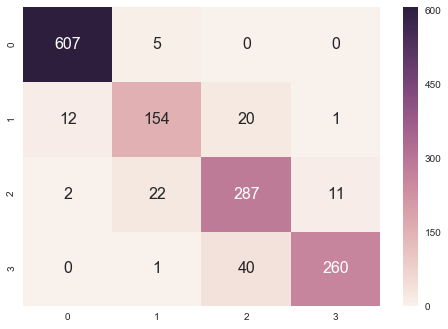

In [181]:
print_metrics(best_unbalanced, featuresCV, labelsCV, 'žiadne', phase_num)

#### Class weights

In [182]:
labels_weights = class_weight.compute_sample_weight('balanced', labels)

In [183]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [184]:
%%time
gs.fit(features, labels, sample_weight=labels_weights)

Wall time: 18min 34s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [185]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.91842, std: 0.00620, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.91772, std: 0.00556, params: {'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.91702, std: 0.00491, params: {'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.91702, std: 0.00328, params: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.91702, std: 0.00750, params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.91684, std: 0.00752, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.91667, std: 0.00362, params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.91667, std: 0.00628, params: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 50, 'random_state': 64},
 mean: 0.91667, std: 0.00563, params: {'lear

In [186]:
best_weighted = gs.best_estimator_
best_weighted

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.919127988748

             precision    recall  f1-score   support

          1       0.98      0.98      0.98       612
          2       0.81      0.87      0.84       187
          3       0.84      0.88      0.86       322
          4       0.96      0.86      0.91       301

avg / total       0.92      0.92      0.92      1422

macro precision:  0.897378363257
micro precision:  0.919127988748

micro recall:  0.919127988748
macro recall:  0.898720414415

micro f1:  0.919127988748
macro f1:  0.897037093217


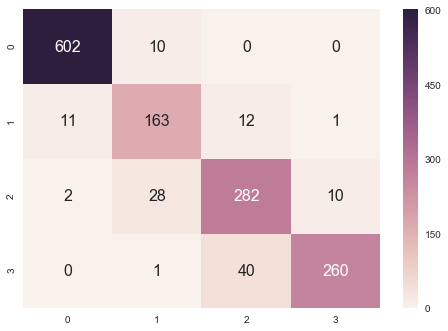

In [187]:
print_metrics(best_weighted, featuresCV, labelsCV, 'váhovanie', phase_num)

#### Oversampling

In [188]:
ros = RandomOverSampler(random_state=64)
features_sampled, labels_sampled = ros.fit_sample(features, labels)
print(sorted(Counter(labels_sampled).items()))

[(1, 2481), (2, 2481), (3, 2481), (4, 2481)]


In [189]:
features_sampled = pd.DataFrame(features_sampled)
features_sampled.columns = features.columns
features_sampled.shape

(9924, 40)

In [190]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [191]:
%%time
gs.fit(features_sampled, labels_sampled)

Wall time: 36min 26s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [192]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.98378, std: 0.01260, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.98378, std: 0.01286, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.98327, std: 0.01275, params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.98297, std: 0.01355, params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.98247, std: 0.01363, params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.98156, std: 0.01228, params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.98126, std: 0.01320, params: {'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 100, 'random_state': 64},
 mean: 0.98065, std: 0.01307, params: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 150, 'random_state': 64},
 mean: 0.98005, std: 0.01307, params: {'learn

In [193]:
best_oversampled = gs.best_estimator_

accuracy:  0.92123769339

             precision    recall  f1-score   support

          1       0.98      0.99      0.99       612
          2       0.84      0.84      0.84       187
          3       0.84      0.88      0.86       322
          4       0.96      0.87      0.91       301

avg / total       0.92      0.92      0.92      1422

macro precision:  0.901587291934
micro precision:  0.92123769339

micro recall:  0.92123769339
macro recall:  0.896461765912

micro f1:  0.92123769339
macro f1:  0.898307212526


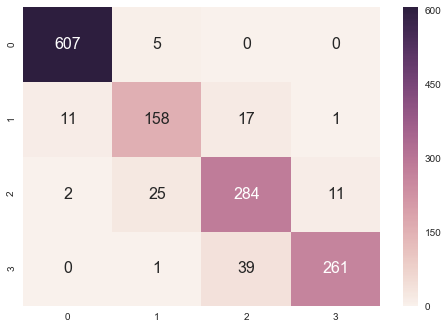

In [194]:
print_metrics(best_oversampled, featuresCV, labelsCV, 'nadvzorkovanie', phase_num)

#### Undersampling

In [195]:
rus = RandomUnderSampler(random_state=64)
features_sampled, labels_sampled = rus.fit_sample(features, labels)
print(sorted(Counter(labels_sampled).items()))

[(1, 741), (2, 741), (3, 741), (4, 741)]


In [196]:
features_sampled = pd.DataFrame(features_sampled)
features_sampled.columns = features.columns
features_sampled.shape

(2964, 40)

In [197]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [198]:
%%time
gs.fit(features_sampled, labels_sampled)

Wall time: 10min 33s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [199]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.89372, std: 0.01306, params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.89238, std: 0.01170, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.89238, std: 0.01304, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.89170, std: 0.01043, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.89170, std: 0.01426, params: {'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150, 'random_state': 64},
 mean: 0.89170, std: 0.01090, params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'random_state': 64},
 mean: 0.89136, std: 0.01373, params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 64},
 mean: 0.89136, std: 0.01398, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.89136, std: 0.01156, params: {'learni

In [200]:
best_undersampled = gs.best_estimator_
best_undersampled

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.912798874824

             precision    recall  f1-score   support

          1       0.98      0.97      0.98       612
          2       0.76      0.88      0.82       187
          3       0.85      0.86      0.86       322
          4       0.95      0.87      0.91       301

avg / total       0.92      0.91      0.91      1422

macro precision:  0.886979073101
micro precision:  0.912798874824

micro recall:  0.912798874824
macro recall:  0.894554909625

micro f1:  0.912798874824
macro f1:  0.889263831316


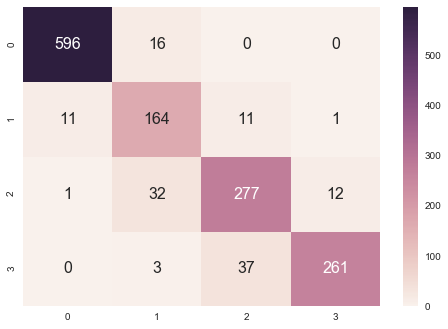

In [201]:
print_metrics(best_undersampled, featuresCV, labelsCV, 'podvzorkovanie', phase_num)

### Best configuration (primary: accuracy, secondary: macro F1)

In [202]:
df_results[['Fáza','Vyváženie','S','P_0','P_1','P_2','P_3','Ú_0','Ú_1','Ú_2','Ú_3', 'F1_makro']] \
.sort_values(by=['Fáza', 'S', 'F1_makro'], ascending=False)

,Fáza,Vyváženie,S,P_0,P_1,P_2,P_3,Ú_0,Ú_1,Ú_2,Ú_3,F1_makro
12,4,žiadne,0.92,0.98,0.85,0.83,0.96,0.99,0.82,0.89,0.86,0.90
13,4,váhovanie,0.92,0.98,0.81,0.84,0.96,0.98,0.87,0.88,0.86,0.90
14,4,nadvzorkovanie,0.92,0.98,0.84,0.84,0.96,0.99,0.84,0.88,0.87,0.90
15,4,podvzorkovanie,0.91,0.98,0.76,0.85,0.95,0.97,0.88,0.86,0.87,0.89
8,3,žiadne,0.85,0.96,0.70,0.69,0.88,0.99,0.66,0.75,0.77,0.80
9,3,váhovanie,0.84,0.96,0.67,0.69,0.87,0.98,0.71,0.73,0.76,0.80
10,3,nadvzorkovanie,0.84,0.96,0.67,0.69,0.87,0.99,0.69,0.72,0.76,0.79
11,3,podvzorkovanie,0.84,0.98,0.60,0.71,0.87,0.96,0.81,0.68,0.77,0.79
4,2,žiadne,0.81,0.92,0.60,0.66,0.87,0.98,0.52,0.72,0.77,0.75
5,2,váhovanie,0.81,0.93,0.55,0.67,0.88,0.97,0.58,0.68,0.78,0.75


In [203]:
best = best_unbalanced
best

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

In [204]:
importances = pd.DataFrame()
for i, name, importance in zip(range(len(features.columns)), features.columns, best.feature_importances_):
    importances.loc[i, 'názov črty'] = name
    importances.loc[i, 'dôležitosť'] = importance
    
importances.sort_values(by='dôležitosť', ascending=False).to_csv('results/importances'+ str(phase_num) +'.csv')
importances.sort_values(by='dôležitosť', ascending=False)

,názov črty,dôležitosť
3,ratio_pledged_goal,0.277490
31,LDA_10,0.031919
20,LSA_16,0.029350
25,LDA_1,0.028414
28,LDA_4,0.027534
17,LSA_12,0.025423
37,LDA_21,0.025054
4,ratio_running_duration,0.024451
5,usd_goal,0.022782
0,average_pledge,0.022484


### Save confusion matrices

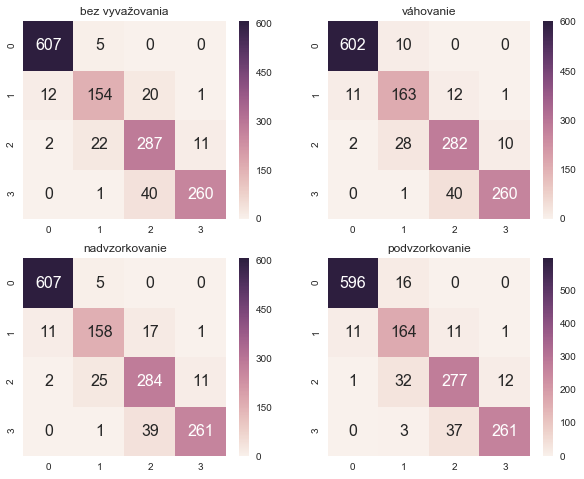

In [205]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(10, 8))

sns.heatmap(metrics.confusion_matrix(labelsCV, best_unbalanced.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[0][0])
ax[0][0].set(xlabel='', ylabel='', title='bez vyvažovania')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_weighted.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[0][1])
ax[0][1].set(xlabel='', ylabel='', title='váhovanie')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_oversampled.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[1][0])
ax[1][0].set(xlabel='', ylabel='', title='nadvzorkovanie')

sns.heatmap(metrics.confusion_matrix(labelsCV, best_undersampled.predict(featuresCV)), annot=True, fmt='g', annot_kws={"size": 16}, ax=ax[1][1])
ax[1][1].set(xlabel='', ylabel='', title='podvzorkovanie')

fig.savefig('img/matrices4.png', dpi=400)

In [206]:
df_results[['Fáza','Vyváženie','S','P_0','P_1','P_2','P_3','Ú_0','Ú_1','Ú_2','Ú_3', 'F1_makro']].to_csv('results/final.csv')

# Experiments

## 0-5% of campaign duration

In [207]:
features = pd.read_csv('data/final/train.csv', index_col=0)
df = pd.read_csv('data/final/test.csv', index_col=0)
features = features.append(df, ignore_index=True)

features = features[features['ratio_running_duration'] < 5]

labels = features['class']
features = features.drop('class', axis=1)

features.shape

(1570, 151)

In [208]:
featuresCV = pd.read_csv('data/final/cv.csv', index_col=0)

featuresCV = featuresCV[featuresCV['ratio_running_duration'] < 5]

labelsCV = featuresCV['class']
featuresCV = featuresCV.drop('class', axis=1)

featuresCV.shape

(432, 151)

### Feature selection

In [209]:
# use features selected for 0-25%

selected_features = ['average_pledge',
 'backers_count',
 'category_position',
 'days_duration',
 'days_preparation',
 'days_remaining',
 'days_running',
 'pledged',
 'ratio_pledged_goal',
 'ratio_running_duration',
 'usd_goal',
 'usd_pledged',
 'comments_count_public_while_scraping',
 'updates_likes_sum_while_scraping',
 'updates_likes_max_while_scraping',
 'deadline_day',
 'deadline_hour',
 'launch_month',
 'launch_day',
 'launch_hour',
 'image_count',
 'blurb_words',
 'category_parent_fashion',
 'location_type_Miscellaneous',
 'LSA_0',
 'LSA_1',
 'LSA_2',
 'LSA_3',
 'LSA_4',
 'LSA_5',
 'LSA_6',
 'LSA_7',
 'LSA_8',
 'LSA_9',
 'LSA_10',
 'LSA_11',
 'LSA_12',
 'LSA_13',
 'LSA_14',
 'LSA_15',
 'LSA_16',
 'LSA_17',
 'LSA_18',
 'LSA_19',
 'LSA_20',
 'LSA_21',
 'LSA_22',
 'LSA_23',
 'LSA_24',
 'LDA_0',
 'LDA_1',
 'LDA_2',
 'LDA_3',
 'LDA_4',
 'LDA_5',
 'LDA_6',
 'LDA_7',
 'LDA_8',
 'LDA_9',
 'LDA_10',
 'LDA_11',
 'LDA_12',
 'LDA_13',
 'LDA_14',
 'LDA_15',
 'LDA_16',
 'LDA_17',
 'LDA_18',
 'LDA_19',
 'LDA_20',
 'LDA_21',
 'LDA_22',
 'LDA_23',
 'LDA_24']

In [210]:
features = features[selected_features]
features.shape

(1570, 74)

In [211]:
featuresCV = featuresCV[selected_features]
featuresCV.shape

(432, 74)

In [212]:
pd.Series(features.columns == featuresCV.columns).value_counts()

True    74
dtype: int64

### Training

#### Unbalanced

In [213]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [214]:
%%time
gs.fit(features, labels)

Wall time: 10min 2s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [215]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.68025, std: 0.01530, params: {'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.67771, std: 0.01862, params: {'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.67771, std: 0.02000, params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.67771, std: 0.01999, params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.67771, std: 0.01635, params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.67771, std: 0.01650, params: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 50, 'random_state': 64},
 mean: 0.67643, std: 0.01931, params: {'learning_rate': 0.08, 'max_depth': 1, 'n_estimators': 150, 'random_state': 64},
 mean: 0.67580, std: 0.01837, params: {'learning_rate': 0.08, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.67516, std: 0.02820, params: {'learn

In [216]:
best_unbalanced = gs.best_estimator_
best_unbalanced

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.666666666667

             precision    recall  f1-score   support

          1       0.78      0.92      0.85       182
          2       0.26      0.17      0.20        42
          3       0.49      0.47      0.48       104
          4       0.71      0.62      0.66       104

avg / total       0.64      0.67      0.65       432

macro precision:  0.560441429802
micro precision:  0.666666666667

micro recall:  0.666666666667
macro recall:  0.544070512821

micro f1:  0.666666666667
macro f1:  0.547358032268


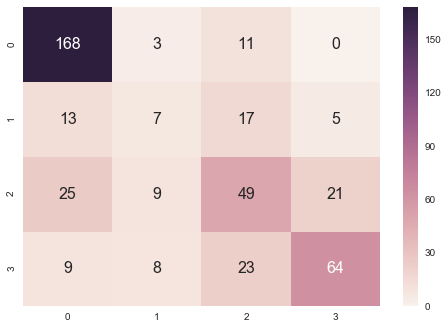

In [217]:
print_metrics(best_unbalanced, featuresCV, labelsCV, 'žiadne', '0-5')

## 5-10% of campaign duration

In [218]:
features = pd.read_csv('data/final/train.csv', index_col=0)
df = pd.read_csv('data/final/test.csv', index_col=0)
features = features.append(df, ignore_index=True)

features = features[(features['ratio_running_duration'] < 10) & (features['ratio_running_duration'] >= 5)]

labels = features['class']
features = features.drop('class', axis=1)

features.shape

(975, 151)

In [219]:
featuresCV = pd.read_csv('data/final/cv.csv', index_col=0)

featuresCV = featuresCV[(featuresCV['ratio_running_duration'] < 10) & (featuresCV['ratio_running_duration'] >= 5)]

labelsCV = featuresCV['class']
featuresCV = featuresCV.drop('class', axis=1)

featuresCV.shape

(260, 151)

### Feature selection

In [220]:
# use features selected for 0-25%

selected_features = ['average_pledge',
 'backers_count',
 'category_position',
 'days_duration',
 'days_preparation',
 'days_remaining',
 'days_running',
 'pledged',
 'ratio_pledged_goal',
 'ratio_running_duration',
 'usd_goal',
 'usd_pledged',
 'comments_count_public_while_scraping',
 'updates_likes_sum_while_scraping',
 'updates_likes_max_while_scraping',
 'deadline_day',
 'deadline_hour',
 'launch_month',
 'launch_day',
 'launch_hour',
 'image_count',
 'blurb_words',
 'category_parent_fashion',
 'location_type_Miscellaneous',
 'LSA_0',
 'LSA_1',
 'LSA_2',
 'LSA_3',
 'LSA_4',
 'LSA_5',
 'LSA_6',
 'LSA_7',
 'LSA_8',
 'LSA_9',
 'LSA_10',
 'LSA_11',
 'LSA_12',
 'LSA_13',
 'LSA_14',
 'LSA_15',
 'LSA_16',
 'LSA_17',
 'LSA_18',
 'LSA_19',
 'LSA_20',
 'LSA_21',
 'LSA_22',
 'LSA_23',
 'LSA_24',
 'LDA_0',
 'LDA_1',
 'LDA_2',
 'LDA_3',
 'LDA_4',
 'LDA_5',
 'LDA_6',
 'LDA_7',
 'LDA_8',
 'LDA_9',
 'LDA_10',
 'LDA_11',
 'LDA_12',
 'LDA_13',
 'LDA_14',
 'LDA_15',
 'LDA_16',
 'LDA_17',
 'LDA_18',
 'LDA_19',
 'LDA_20',
 'LDA_21',
 'LDA_22',
 'LDA_23',
 'LDA_24']

In [221]:
features = features[selected_features]
features.shape

(975, 74)

In [222]:
featuresCV = featuresCV[selected_features]
featuresCV.shape

(260, 74)

In [223]:
pd.Series(features.columns == featuresCV.columns).value_counts()

True    74
dtype: int64

### Training

#### Unbalanced

In [224]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [225]:
%%time
gs.fit(features, labels)

Wall time: 6min 44s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [226]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.74564, std: 0.02289, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 50, 'random_state': 64},
 mean: 0.74462, std: 0.02957, params: {'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 50, 'random_state': 64},
 mean: 0.74256, std: 0.02088, params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.74256, std: 0.02191, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 100, 'random_state': 64},
 mean: 0.74154, std: 0.01860, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.74154, std: 0.01856, params: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.74051, std: 0.02114, params: {'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.74051, std: 0.01688, params: {'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.74051, std: 0.01692, params: {'learni

In [227]:
best_unbalanced = gs.best_estimator_
best_unbalanced

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.742307692308

             precision    recall  f1-score   support

          1       0.84      0.98      0.90       110
          2       0.46      0.14      0.21        43
          3       0.62      0.75      0.68        60
          4       0.74      0.72      0.73        47

avg / total       0.71      0.74      0.71       260

macro precision:  0.665719549662
micro precision:  0.742307692308

micro recall:  0.742307692308
macro recall:  0.648689330215

micro f1:  0.742307692308
macro f1:  0.632763095545


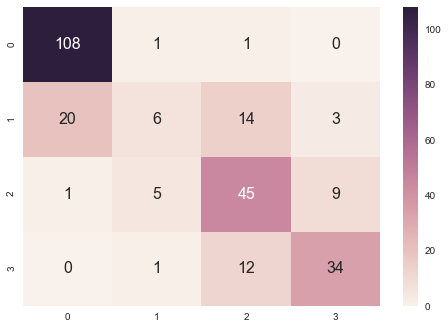

In [228]:
print_metrics(best_unbalanced, featuresCV, labelsCV, 'žiadne', '0-5')

## 20-25% of campaign duration

In [229]:
features = pd.read_csv('data/final/train.csv', index_col=0)
df = pd.read_csv('data/final/test.csv', index_col=0)
features = features.append(df, ignore_index=True)

features = features[(features['ratio_running_duration'] < 25) & (features['ratio_running_duration'] >= 20)]

labels = features['class']
features = features.drop('class', axis=1)

features.shape

(1470, 151)

In [230]:
featuresCV = pd.read_csv('data/final/cv.csv', index_col=0)

featuresCV = featuresCV[(featuresCV['ratio_running_duration'] < 25) & (featuresCV['ratio_running_duration'] >= 20)]

labelsCV = featuresCV['class']
featuresCV = featuresCV.drop('class', axis=1)

featuresCV.shape

(332, 151)

### Feature selection

In [231]:
# use features selected for 0-25%

selected_features = ['average_pledge',
 'backers_count',
 'category_position',
 'days_duration',
 'days_preparation',
 'days_remaining',
 'days_running',
 'pledged',
 'ratio_pledged_goal',
 'ratio_running_duration',
 'usd_goal',
 'usd_pledged',
 'comments_count_public_while_scraping',
 'updates_likes_sum_while_scraping',
 'updates_likes_max_while_scraping',
 'deadline_day',
 'deadline_hour',
 'launch_month',
 'launch_day',
 'launch_hour',
 'image_count',
 'blurb_words',
 'category_parent_fashion',
 'location_type_Miscellaneous',
 'LSA_0',
 'LSA_1',
 'LSA_2',
 'LSA_3',
 'LSA_4',
 'LSA_5',
 'LSA_6',
 'LSA_7',
 'LSA_8',
 'LSA_9',
 'LSA_10',
 'LSA_11',
 'LSA_12',
 'LSA_13',
 'LSA_14',
 'LSA_15',
 'LSA_16',
 'LSA_17',
 'LSA_18',
 'LSA_19',
 'LSA_20',
 'LSA_21',
 'LSA_22',
 'LSA_23',
 'LSA_24',
 'LDA_0',
 'LDA_1',
 'LDA_2',
 'LDA_3',
 'LDA_4',
 'LDA_5',
 'LDA_6',
 'LDA_7',
 'LDA_8',
 'LDA_9',
 'LDA_10',
 'LDA_11',
 'LDA_12',
 'LDA_13',
 'LDA_14',
 'LDA_15',
 'LDA_16',
 'LDA_17',
 'LDA_18',
 'LDA_19',
 'LDA_20',
 'LDA_21',
 'LDA_22',
 'LDA_23',
 'LDA_24']

In [232]:
features = features[selected_features]
features.shape

(1470, 74)

In [233]:
featuresCV = featuresCV[selected_features]
featuresCV.shape

(332, 74)

In [234]:
pd.Series(features.columns == featuresCV.columns).value_counts()

True    74
dtype: int64

### Training

#### Unbalanced

In [235]:
gs = GridSearchCV(GradientBoostingClassifier(), params, scoring='accuracy', cv=5, n_jobs=-1, error_score=0)

In [236]:
%%time
gs.fit(features, labels)

Wall time: 8min 50s


GridSearchCV(cv=5, error_score=0,
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.12, 0.1, 0.08, 0.01, 0.2], 'n_estimators': [150, 100, 50], 'max_depth': [1, 2, 3, 4, 5], 'random_state': [64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [237]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[:10]

C:\Users\Patrik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.78367, std: 0.01293, params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'random_state': 64},
 mean: 0.78095, std: 0.02116, params: {'learning_rate': 0.08, 'max_depth': 1, 'n_estimators': 100, 'random_state': 64},
 mean: 0.78027, std: 0.01839, params: {'learning_rate': 0.12, 'max_depth': 1, 'n_estimators': 50, 'random_state': 64},
 mean: 0.78027, std: 0.01069, params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'random_state': 64},
 mean: 0.77891, std: 0.01126, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.77891, std: 0.01257, params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 150, 'random_state': 64},
 mean: 0.77823, std: 0.01601, params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50, 'random_state': 64},
 mean: 0.77823, std: 0.01159, params: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 50, 'random_state': 64},
 mean: 0.77823, std: 0.00712, params: {'learni

In [238]:
best_unbalanced = gs.best_estimator_
best_unbalanced

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=64, subsample=1.0, verbose=0,
              warm_start=False)

accuracy:  0.765060240964

             precision    recall  f1-score   support

          1       0.92      0.98      0.95       137
          2       0.59      0.43      0.50        51
          3       0.49      0.62      0.55        64
          4       0.85      0.72      0.78        80

avg / total       0.77      0.77      0.76       332

macro precision:  0.714792787684
micro precision:  0.765060240964

micro recall:  0.765060240964
macro recall:  0.6898686847

micro f1:  0.765060240964
macro f1:  0.695626097036


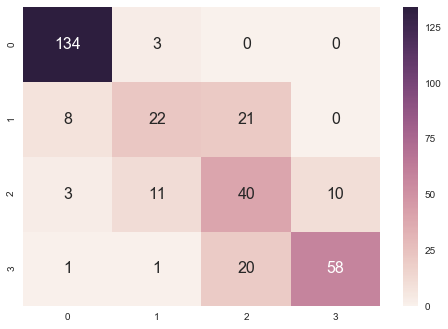

In [239]:
print_metrics(best_unbalanced, featuresCV, labelsCV, 'žiadne', '0-5')

In [240]:
df_results

,F1_makro,Fáza,P_0,P_1,P_2,P_3,S,Vyváženie,Ú_0,Ú_1,Ú_2,Ú_3
0,0.68,1,0.87,0.53,0.60,0.79,0.76,žiadne,0.97,0.41,0.60,0.73
1,0.67,1,0.90,0.42,0.61,0.78,0.73,váhovanie,0.90,0.59,0.51,0.72
2,0.67,1,0.87,0.45,0.58,0.79,0.74,oversampling,0.93,0.44,0.59,0.71
3,0.66,1,0.90,0.40,0.59,0.77,0.72,undersampling,0.89,0.60,0.47,0.71
4,0.75,2,0.92,0.60,0.66,0.87,0.81,žiadne,0.98,0.52,0.72,0.77
5,0.75,2,0.93,0.55,0.67,0.88,0.81,váhovanie,0.97,0.58,0.68,0.78
6,0.75,2,0.93,0.56,0.66,0.87,0.81,nadvzorkovanie,0.98,0.56,0.69,0.77
7,0.74,2,0.94,0.51,0.66,0.86,0.79,podvzorkovanie,0.96,0.66,0.61,0.76
8,0.80,3,0.96,0.70,0.69,0.88,0.85,žiadne,0.99,0.66,0.75,0.77
9,0.80,3,0.96,0.67,0.69,0.87,0.84,váhovanie,0.98,0.71,0.73,0.76
